In [54]:
required_packages <- c("plgp", "lhs", "mvtnorm", "laGP", "hetGP")
install.packages(setdiff(required_packages, rownames(installed.packages())))

In [55]:
library(plgp)

### 6.1.1 Maximum entropy design

In [56]:
maxent <- function(n, m, theta=0.1, g=0.01, T=100000) 
 {  
  if(length(theta) == 1) theta <- rep(theta, m)
  X <- matrix(runif(n*m), ncol=m)
  K <- covar.sep(X, d=theta, g=g) 
  ldetK <- determinant(K, logarithm=TRUE)$modulus

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,] 
    X[row,] <- runif(m)
    Kprime <- covar.sep(X, d=theta, g=g)
    ldetKprime <- determinant(Kprime, logarithm=TRUE)$modulus
    if(ldetKprime > ldetK) { ldetK <- ldetKprime  
    } else { X[row,] <- xold }
  }
  return(X)
}

In [57]:
X <- maxent(25, 2)
X

0.994639868,0.776978726
0.746171024,0.998010947
0.617504126,0.480890926
0.008232281,0.015704742
0.288707249,0.002763248
0.438093471,0.997680959
0.998950940,0.502155417
0.001703183,0.652817957
0.651167297,0.190832049
0.565835481,0.802167392
0.185201750,0.482743603


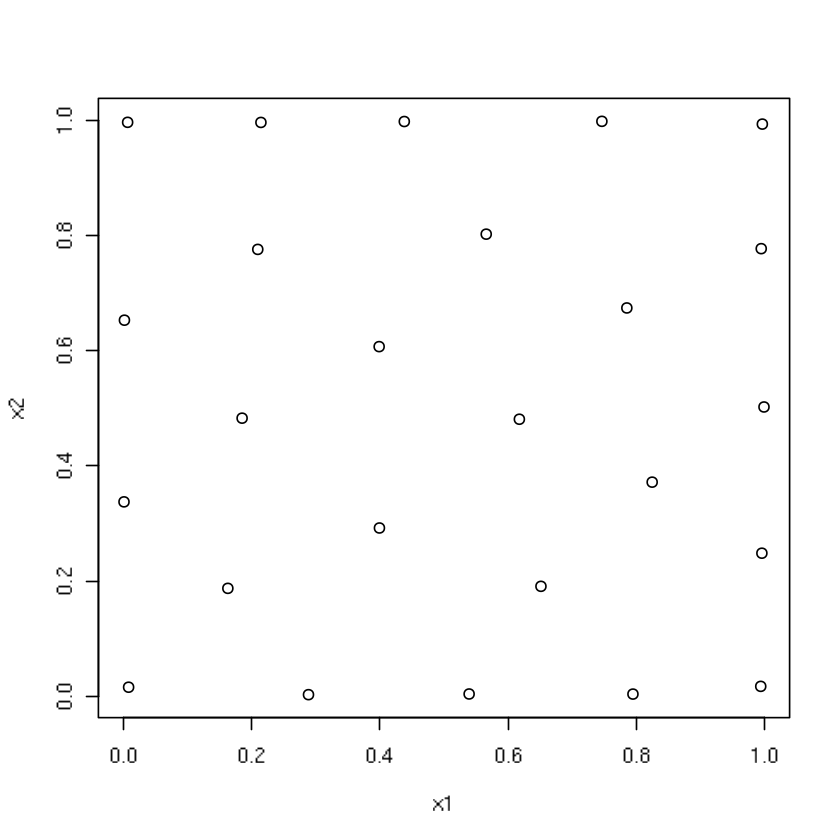

In [58]:
plot(X, xlab="x1", ylab="x2")

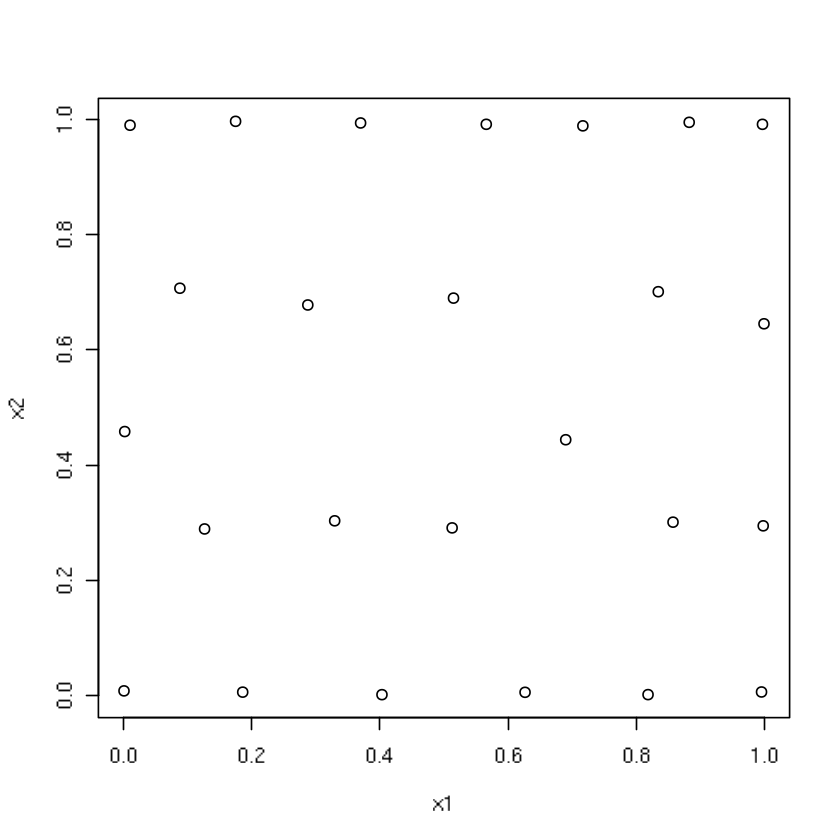

In [59]:
X <- maxent(25, 2, theta=c(0.1, 0.5))
plot(X, xlab="x1", ylab="x2")

In [60]:
X <- maxent(25, 3)

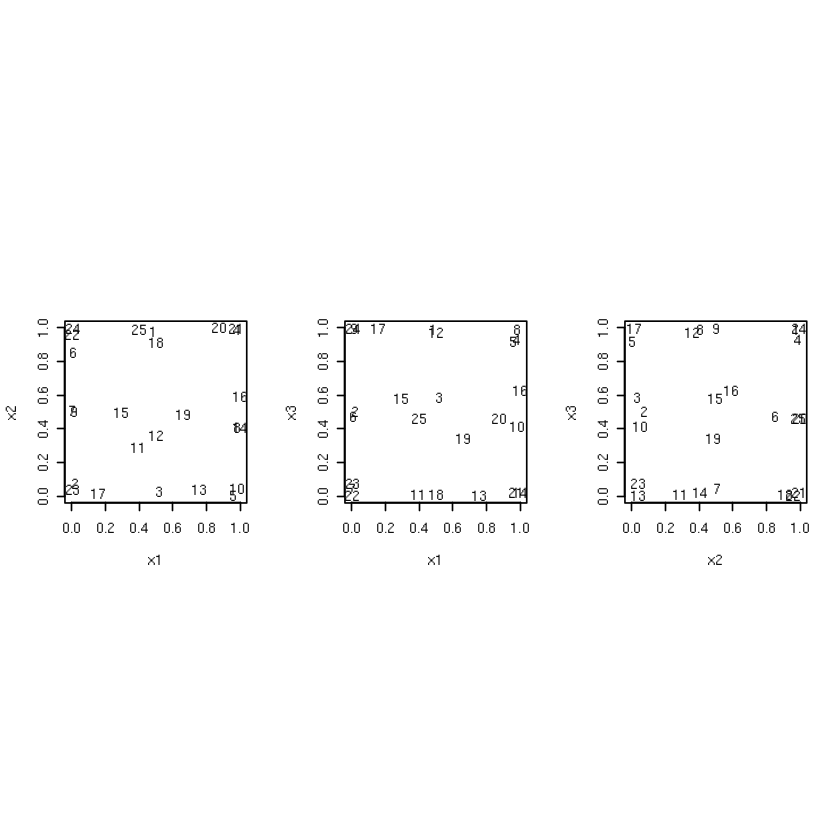

In [61]:
Is <- as.list(as.data.frame(combn(ncol(X),2)))
par(mfrow=c(1,length(Is)), pty="s")
for(i in Is) {
  plot(X[,i], xlim=c(0,1), ylim=c(0,1), type="n",
    xlab=paste0("x", i[1]), ylab=paste0("x", i[2]))
  text(X[,i], labels=1:nrow(X)) 
}

### 6.1.2 Minimizing predictive uncertainty

In [62]:
library(hetGP)
imspe.criteria <- function(X, theta, g, ...) 
 {
  IMSPE(X, theta=theta, Lambda=diag(g, nrow(X)), covtype="Gaussian",
    mult=rep(1, nrow(X)), nu=1) 
 }

In [63]:
imspe <- function(n, m, theta=0.1, g=0.01, T=100000, ...) 
 {  
  if(length(theta) == 1) theta <- rep(theta, m)
  X <- matrix(runif(n*m), ncol=m)
  I <- imspe.criteria(X, theta, g, ...)

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,] 
    X[row,] <- runif(m)
    Iprime <- imspe.criteria(X, theta, g, ...)
    if(Iprime < I) { I <- Iprime 
    } else { X[row,] <- xold }
  }
  return(X)
}

In [64]:
options(warn=-1)
X <- imspe(25, 2)

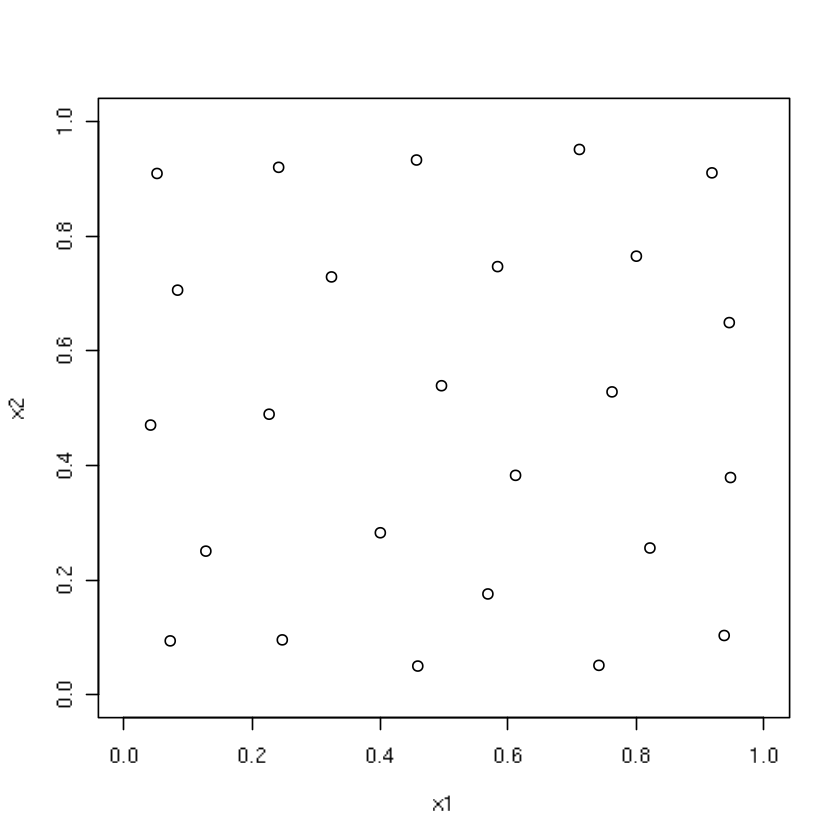

In [65]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))

In [66]:
X <- imspe(25, 3)

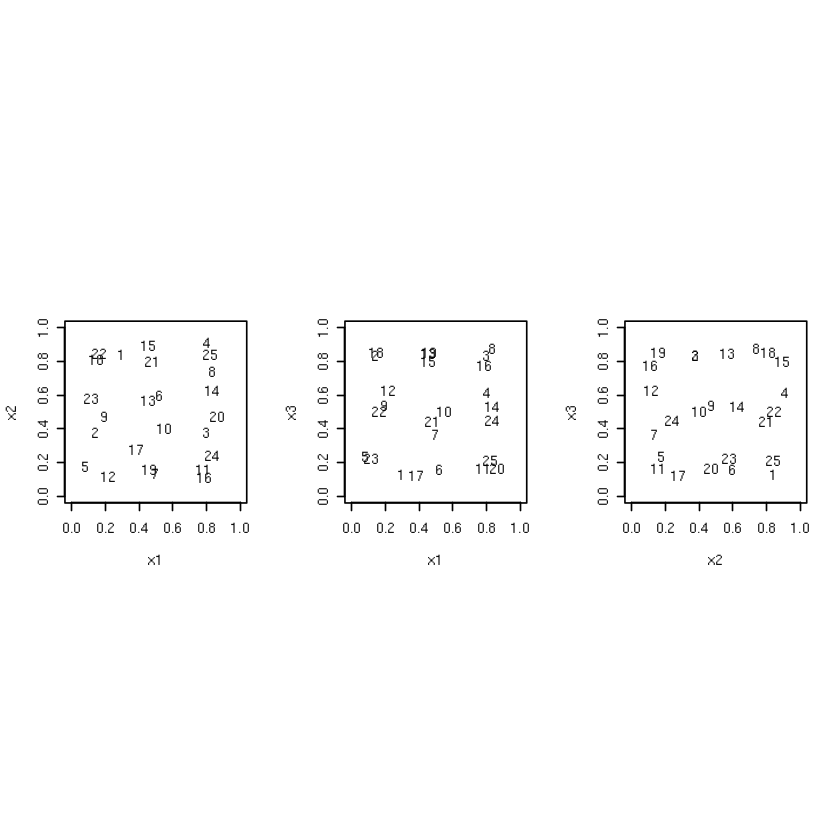

In [67]:
Is <- as.list(as.data.frame(combn(ncol(X),2)))
par(mfrow=c(1,length(Is)), pty="s")
for(i in Is) {
  plot(X[,i], xlim=c(0,1), ylim=c(0,1), type="n",
    xlab=paste0("x", i[1]), ylab=paste0("x", i[2]))
  text(X[,i], labels=1:nrow(X)) 
}

In [68]:
imspe.criteria <- function(X, theta, g, Xref) {
  K <- covar.sep(X, d=theta, g=g)
  Ki <- solve(K)
  KXref <- covar.sep(X, Xref, d=theta, g=0)
  return(mean(1 + g - diag(t(KXref) %*% Ki %*% KXref)))
}

In [69]:
g <- expand.grid(seq(0,1,length=10), seq(0,1,length=10))
X <- imspe(25, 2, Xref=g)

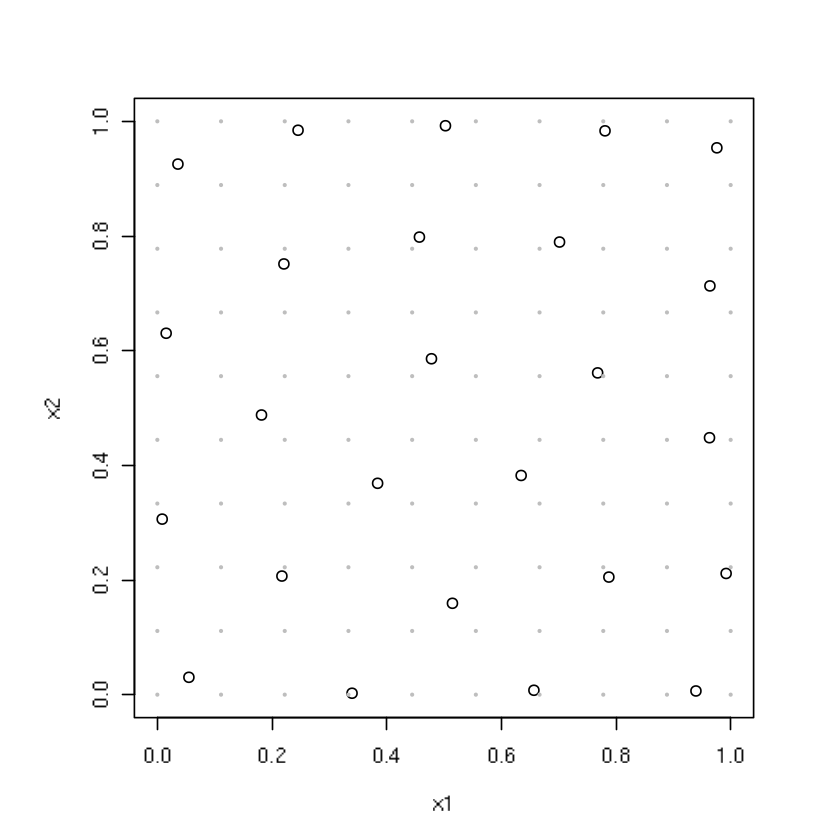

In [70]:
par(pty="s")
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
points(g, pch=20, cex=0.25, col="gray")

In [71]:
Xref <- rmvnorm(100, mean=c(0.25, 0.25),
       sigma=0.005*rbind(c(2, 0.35), c(0.35, 0.1)))
Xref <- rbind(Xref, rmvnorm(100, mean=c(0.25, 0.25),
       sigma=0.005*rbind(c(0.1, -0.35), c(-0.35, 2))))
X <- imspe(25, 2, Xref=Xref)

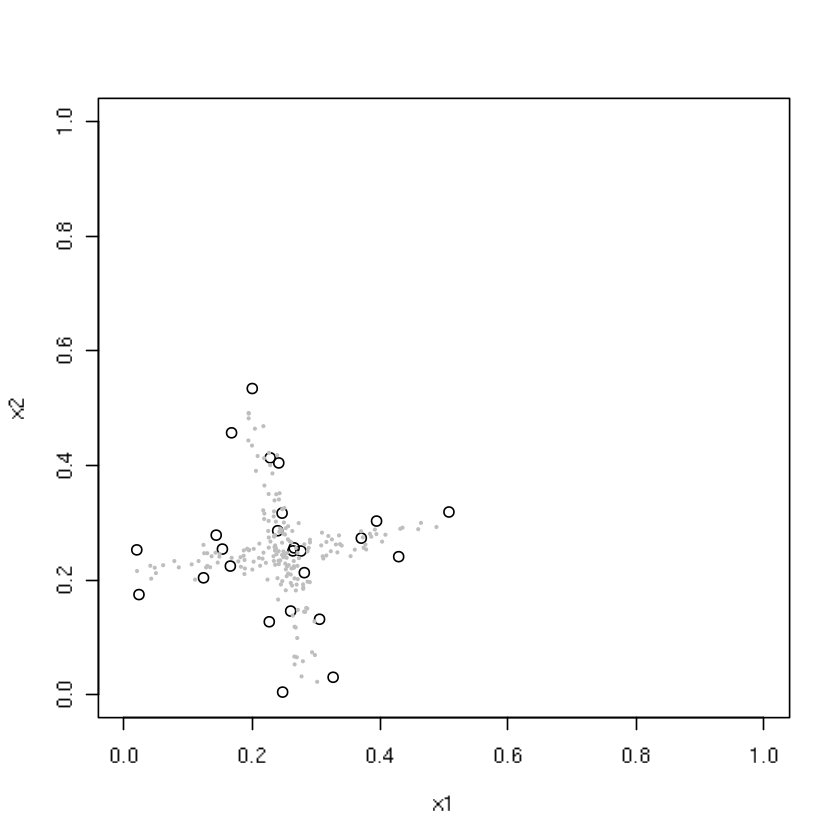

In [72]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
points(Xref, pch=20, cex=0.25, col="gray")

### 6.2.1 Whack-a-mole: active learning MacKay

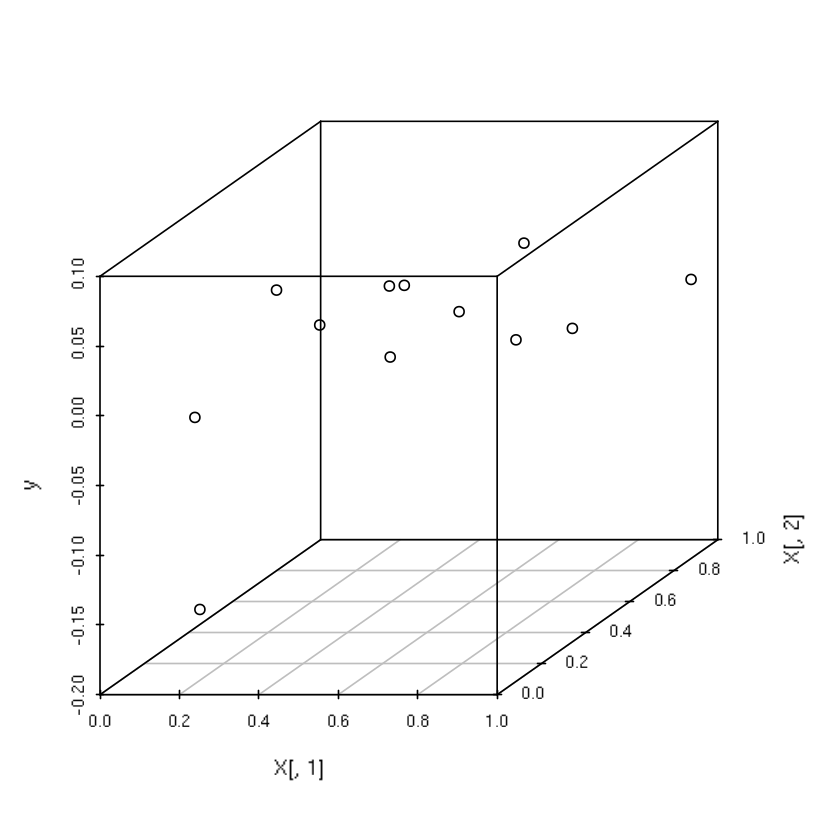

In [73]:
library(lhs)
ninit <- 12
X <- randomLHS(ninit, 2)

f <- function(X, sd=0.01) {
  X[,1] <- (X[,1] - 0.5)*6 + 1
  X[,2] <- (X[,2] - 0.5)*6 + 1
  y <- X[,1] * exp(-X[,1]^2 - X[,2]^2) + rnorm(nrow(X), sd=sd)
}

y <- f(X)

library(scatterplot3d)
scatterplot3d(x = X[,1], y = X[,2], z = y)

In [74]:
library(laGP)
g <- garg(list(mle=TRUE, max=1), y)
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=d$start, g= g$start, dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)

In [75]:
x1 <- x2 <- seq(0, 1, length=100)
XX <- expand.grid(x1, x2)
yytrue <- f(XX, sd=0.0)

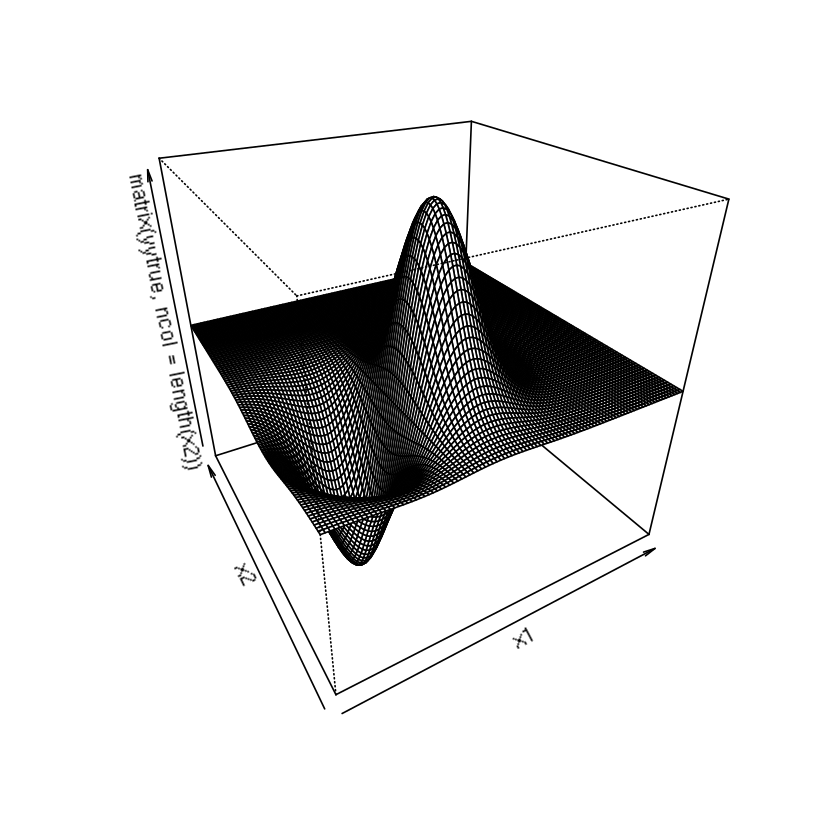

In [76]:
persp(x=x1, y=x2, z=matrix(yytrue, ncol=length(x2)), theta=-30, phi=30)

In [77]:
rmse <- sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2))
rmse

[1] 0.08015651

In [78]:
obj.alm <- function(x, gpi) 
  - sqrt(predGP(gpi, matrix(x, nrow=1), lite=TRUE)$s2)

In [79]:
## from 4.2.1 copied-pasted
mymaximin <- function(n, m, T=100000, Xorig=NULL) 
 {   
  X <- matrix(runif(n*m), ncol=m)     ## initial design
  d <- distance(X)
  d <- d[upper.tri(d)]
  md <- min(d)
  if(!is.null(Xorig)) {               ## new code
    md2 <- min(distance(X, Xorig))
    if(md2 < md) md <- md2
  }

  for(t in 1:T) {
    row <- sample(1:n, 1)
    xold <- X[row,]                   ## random row selection
    X[row,] <- runif(m)               ## random new row
    d <- distance(X)
    d <- d[upper.tri(d)]
    mdprime <- min(d)
    if(!is.null(Xorig)) {             ## new code
      mdprime2 <- min(distance(X, Xorig))
      if(mdprime2 < mdprime) mdprime <- mdprime2
    }
    if(mdprime > md) { md <- mdprime  ## accept
    } else { X[row,] <- xold }        ## reject
  }
  
  return(X)
}


In [80]:
xnp1.search <- function(X, gpi, obj=obj.alm, ...)
 {
  start <- mymaximin(nrow(X), 2, T=100*nrow(X), Xorig=X)
  xnew <- matrix(NA, nrow=nrow(start), ncol=ncol(X) + 1)
  for(i in 1:nrow(start)) {
    out <- optim(start[i,], obj, method="L-BFGS-B", lower=0, 
      upper=1, gpi=gpi, ...)
    xnew[i,] <- c(out$par, -out$value)
  }
  solns <- data.frame(cbind(start, xnew))
  names(solns) <- c("s1", "s2", "x1", "x2", "val")
  return(solns)
 }

In [81]:
solns <- xnp1.search(X, gpi)
solns

s1,s2,x1,x2,val
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.64790745,0.63491021,0.7196391,0.7766834,0.05061470
0.79313103,0.04215914,1.0000000,0.0000000,0.05803132
0.51860433,0.34412706,0.3464092,0.3628302,0.04801068
0.91591821,0.70307448,0.7196391,0.7766834,0.05061470
0.16851002,0.52925876,0.3464093,0.3628301,0.04801068
0.35820379,0.23682835,0.3464125,0.3628323,0.04801068
0.15107810,0.95830196,0.0000000,1.0000000,0.05537350
0.95846193,0.19185539,1.0000000,0.0000000,0.05803132
0.34276095,0.43408260,0.3464083,0.3628342,0.04801068


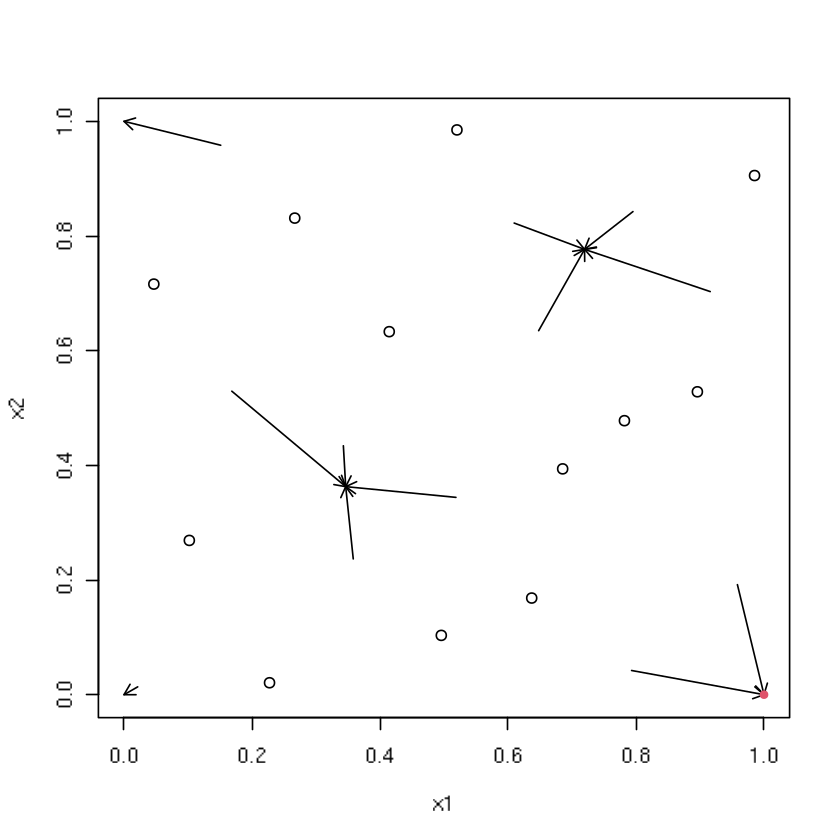

In [82]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
m <- which.max(solns$val)
prog <- solns$val[m]
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [83]:
xnew <- as.matrix(solns[m, 3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
X

,x1,x2
,0.68541471,0.39382925
,0.89591507,0.52827012
,0.41444729,0.63313553
,0.98524108,0.90546182
,0.52023708,0.98502158
,0.04662103,0.71609818
,0.49577773,0.10340174
,0.78192913,0.47787704
,0.22739728,0.02076373
,0.26682149,0.83121416


In [84]:
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
rmse <- c(rmse, sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2)))

In [85]:
solns <- xnp1.search(X, gpi)
m <- which.max(solns$val)
prog <- c(prog, solns$val[m])
xnew <- as.matrix(solns[m, 3:4])
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
p <- predGP(gpi, XX, lite=TRUE)
rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))


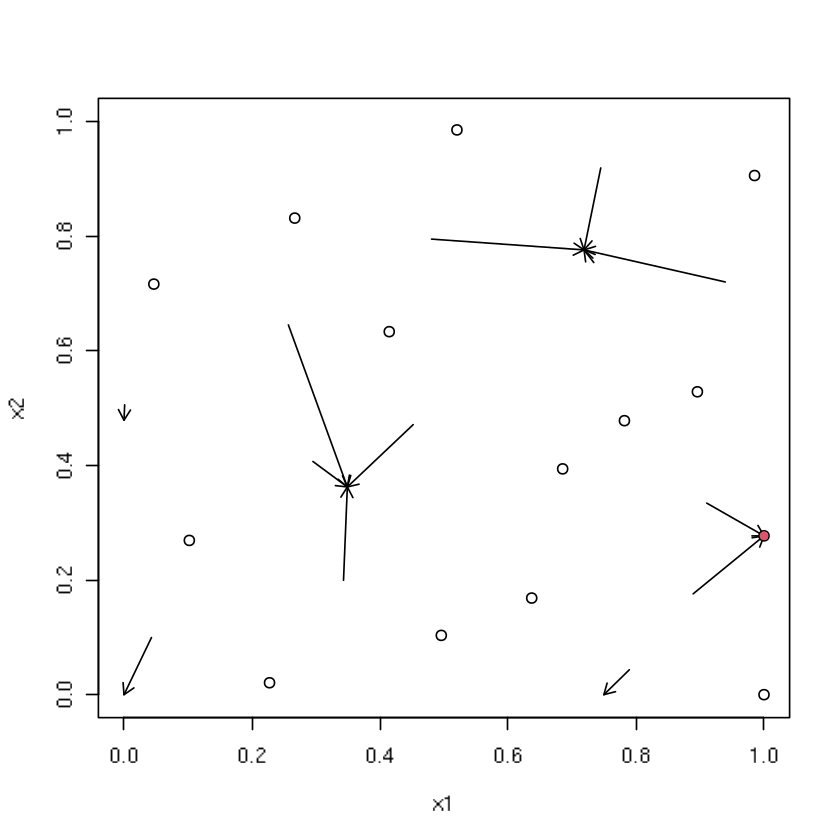

In [86]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
m <- which.max(solns$val)
points(solns$x1[m], solns$x2[m], col=2, pch=20)

In [87]:
for(i in nrow(X):24) {
  solns <- xnp1.search(X, gpi)
  m <- which.max(solns$val)
  prog <- c(prog, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))
}

In [88]:
mle[seq(1,nrow(mle),by=2),]

,d,g,tot.its,dits,gits
,<dbl>,<dbl>,<int>,<int>,<int>
1,0.06643198,0.0003605585,21,6,15
3,0.06342527,0.0003608317,7,4,3
5,0.06405874,0.0003612907,7,4,3
7,0.03046806,0.0003595222,8,5,3
9,0.02976114,0.0003595421,6,4,2
11,0.01898235,0.0003597144,8,6,2
13,0.02002545,0.0003597017,6,4,2


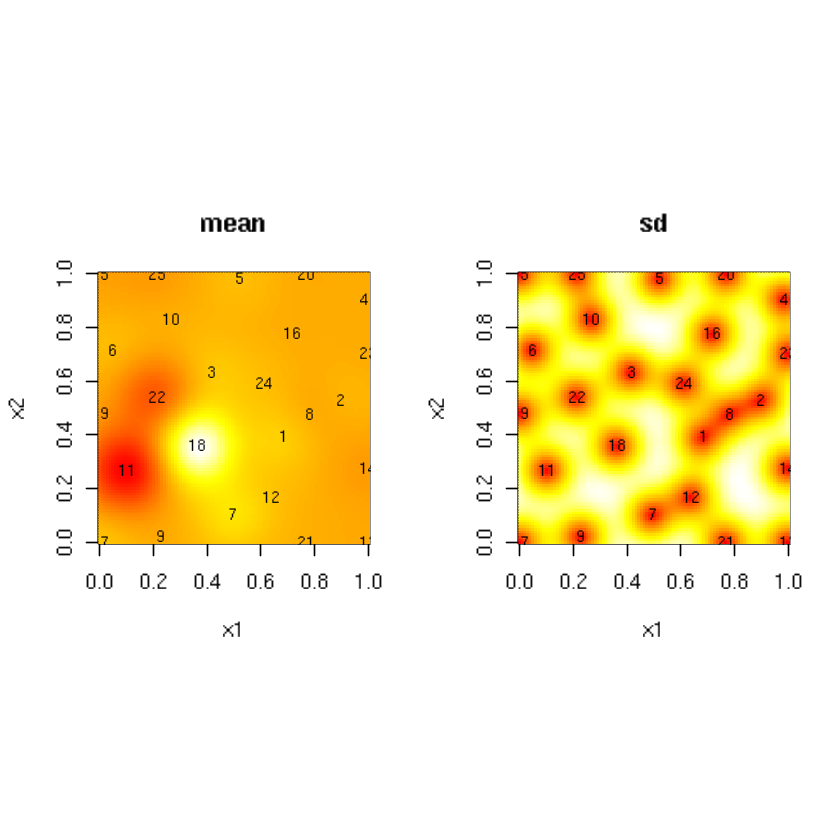

In [89]:
par(mfrow=c(1,2), pty="s")
cols <- heat.colors(128)
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)

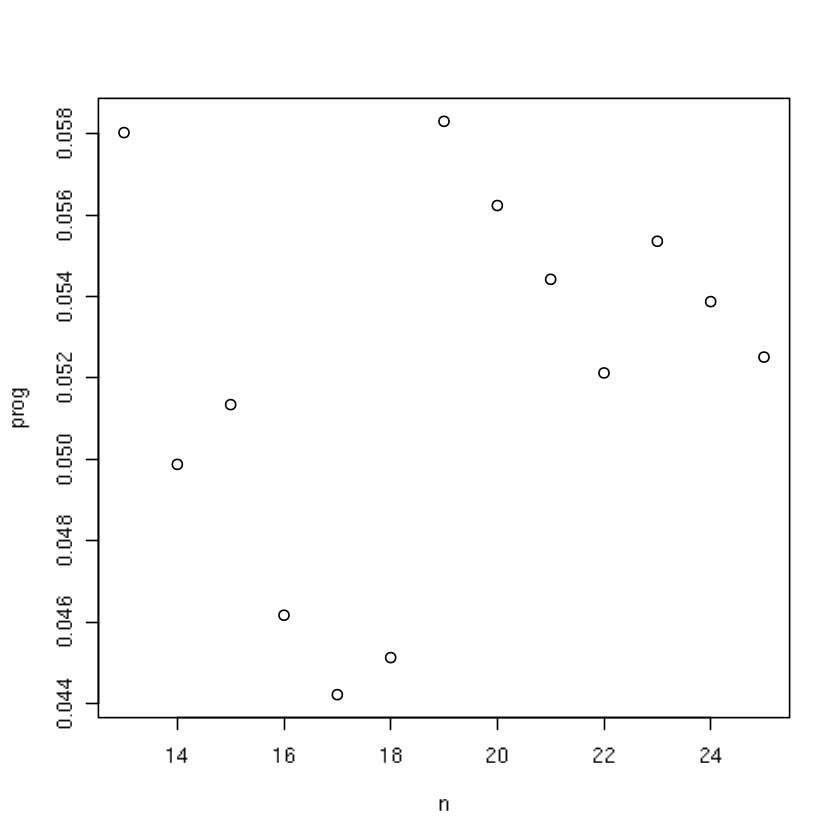

In [90]:
plot((ninit+1):nrow(X), prog, xlab="n")

In [91]:
d <- darg(list(mle=TRUE), X)
for(i in nrow(X):99) {
  solns <- xnp1.search(X, gpi)
  m <- which.max(solns$val)
  prog <- c(prog, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse <- c(rmse, sqrt(mean((yytrue - p$mean)^2)))
}

In [92]:
mle[seq(14,nrow(mle), by=10),]

,d,g,tot.its,dits,gits
,<dbl>,<dbl>,<int>,<int>,<int>
14,0.02058656,0.0003596907,6,4,2
24,0.03393024,0.0003592813,7,4,3
34,0.03249215,0.0003588643,7,4,3
44,0.03201475,0.0003613271,7,4,3
54,0.03040721,0.0003592535,11,6,5
64,0.03225205,0.0003463011,6,3,3
74,0.03228054,0.0004125274,17,8,9
84,0.03178496,0.0003419727,11,6,5


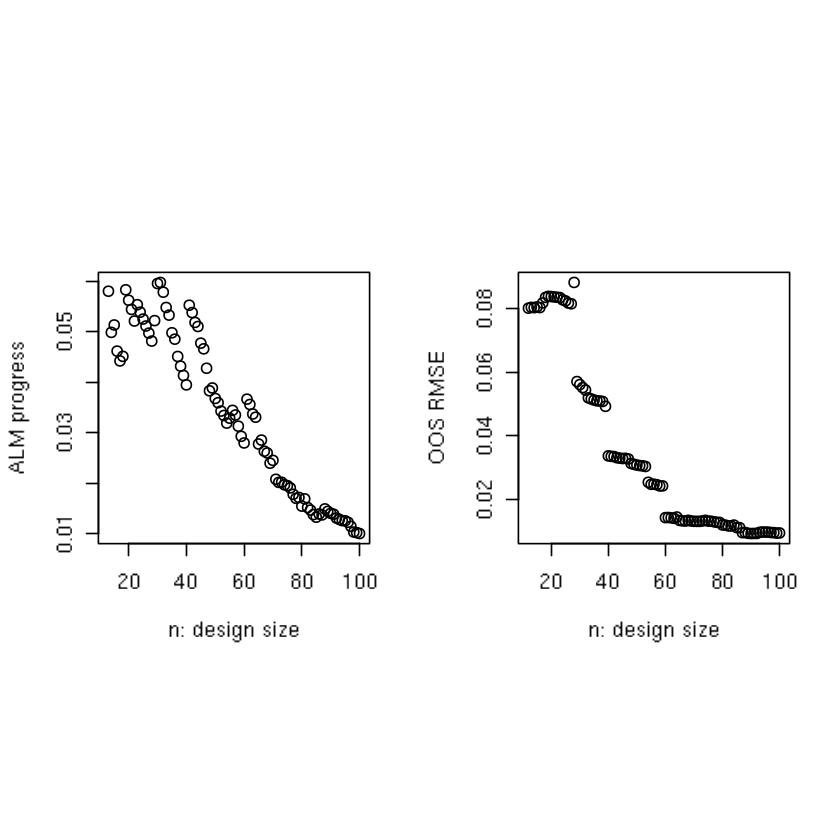

In [93]:
par(mfrow=c(1,2), pty="s")
plot((ninit+1):nrow(X), prog, xlab="n: design size", ylab="ALM progress")
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")

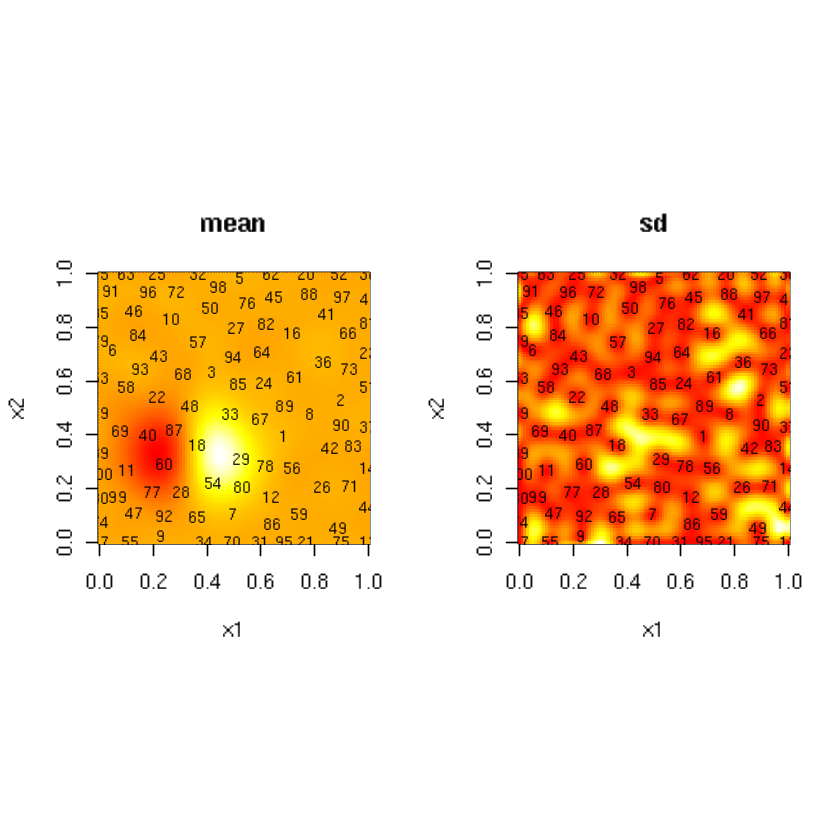

In [94]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)

### 6.2.2 A More aggregate criteria: active learning Cohn

In [95]:
obj.alc <- function(x, gpi, Xref) 
  - sqrt(alcGP(gpi, matrix(x, nrow=1), Xref))

In [96]:
deleteGP(gpi)
X <- X[1:ninit,]
y <- y[1:ninit]
g <- garg(list(mle=TRUE, max=1), y)
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=d$start, g=g$start, dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)
p <- predGP(gpi, XX, lite=TRUE)
rmse.alc <- sqrt(mean((yytrue - p$mean)^2))

In [97]:
Xref <- randomLHS(100, 2)
solns <- xnp1.search(X, gpi, obj=obj.alc, Xref=Xref)
m <- which.max(solns$val)
xnew <- as.matrix(solns[m, 3:4])
prog.alc <- solns$val[m]

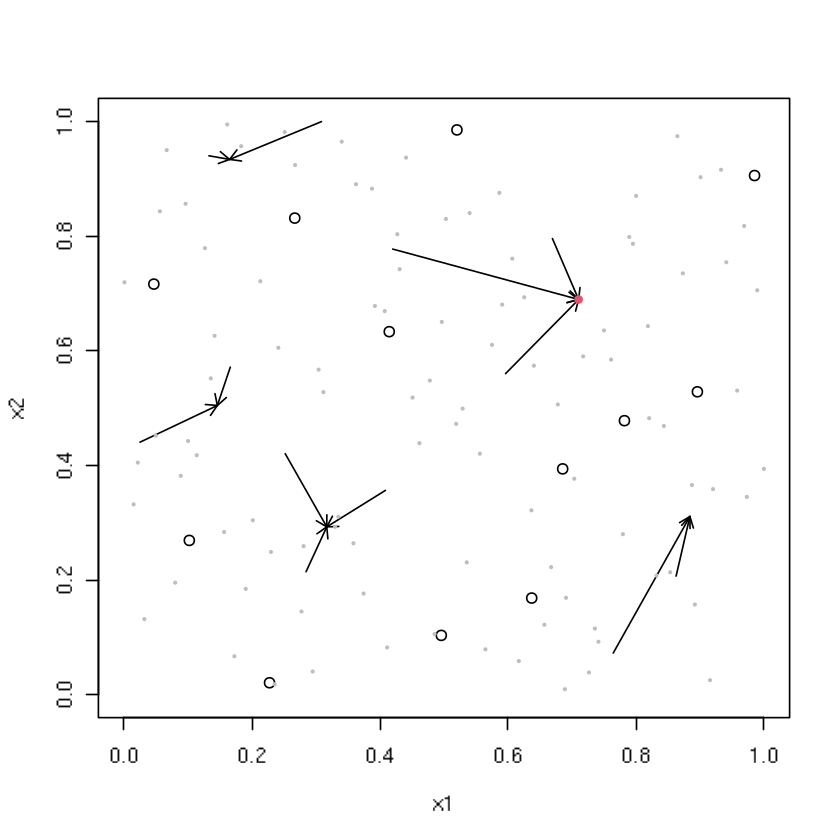

In [98]:
plot(X, xlab="x1", ylab="x2", xlim=c(0,1), ylim=c(0,1))
arrows(solns$s1, solns$s2, solns$x1, solns$x2, length=0.1)
points(solns$x1[m], solns$x2[m], col=2, pch=20)
points(Xref, cex=0.25, pch=20, col="gray")

In [99]:
X <- rbind(X, xnew)
y <- c(y, f(xnew))
updateGP(gpi, xnew, y[length(y)])
mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
  d$ab, g$ab))
p <- predGP(gpi, XX, lite=TRUE)
rmse.alc <- c(rmse.alc, sqrt(mean((yytrue - p$mean)^2)))

In [100]:
d <- darg(list(mle=TRUE), X)
for(i in nrow(X):99) {
  Xref <- randomLHS(100, 2)
  solns <- xnp1.search(X, gpi, obj=obj.alc, Xref=Xref)
  m <- which.max(solns$val)
  prog.alc <- c(prog.alc, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <- predGP(gpi, XX, lite=TRUE)
  rmse.alc <- c(rmse.alc, sqrt(mean((yytrue - p$mean)^2)))
}

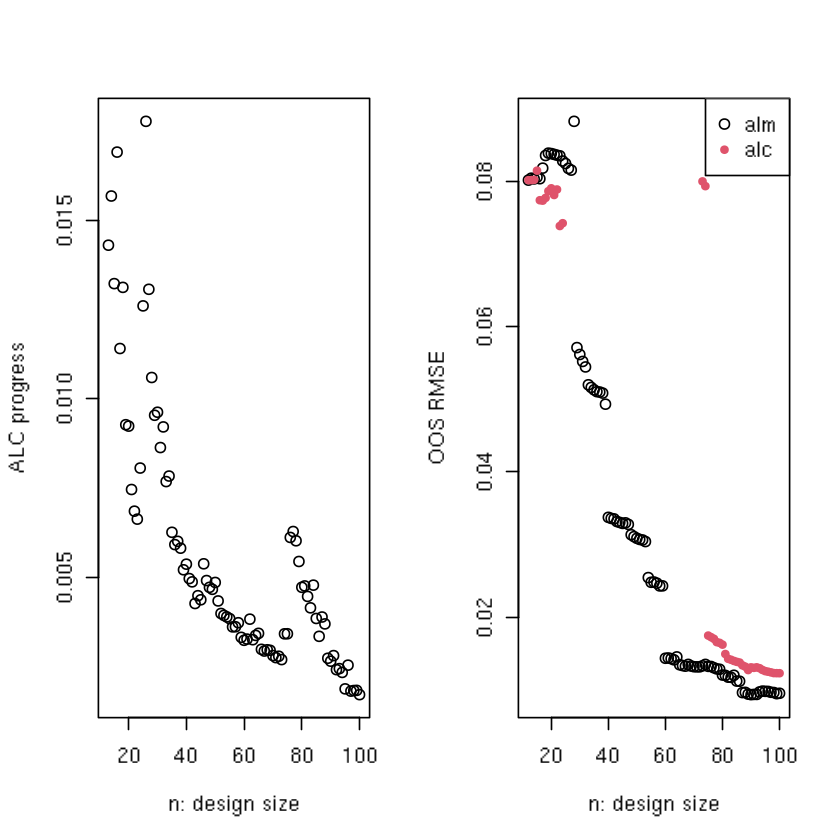

In [101]:
par(mfrow=c(1,2))
plot((ninit+1):nrow(X), prog.alc, xlab="n: design size", 
  ylab="ALC progress")
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")
points(ninit:nrow(X), rmse.alc, col=2, pch=20)
legend("topright", c("alm", "alc"), pch=c(21,20), col=1:2)


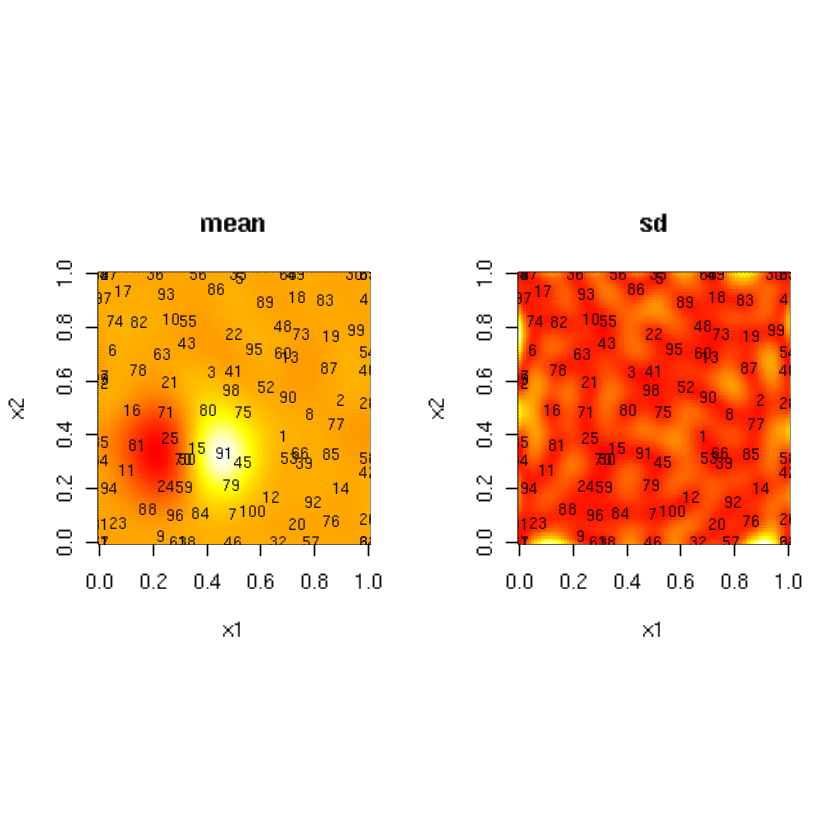

In [102]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)


### 6.2.3 Other sequential criteria

In [103]:
obj.fish <- function(x, gpi) 
  - sqrt(fishGP(gpi, matrix(x, nrow=1)))

In [104]:
X <- X[1:ninit,]
y <- y[1:ninit]
d <- darg(list(mle=TRUE, max=0.25), X)
gpi <- newGP(X, y, d=0.1, g=0.1*var(y), dK=TRUE)
mle <- jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), d$ab, g$ab)
rmse.fish <- sqrt(mean((yytrue - predGP(gpi, XX, lite=TRUE)$mean)^2))
prog.fish <- c()
for(i in nrow(X):99) {
  solns <- xnp1.search(X, gpi, obj=obj.fish)
  m <- which.max(solns$val)
  prog.fish <- c(prog.fish, solns$val[m])
  xnew <- as.matrix(solns[m, 3:4])
  X <- rbind(X, xnew)
  y <- c(y, f(xnew))
  updateGP(gpi, xnew, y[length(y)])
  mle <- rbind(mle, jmleGP(gpi, c(d$min, d$max), c(g$min, g$max), 
    d$ab, g$ab))
  p <-predGP(gpi, XX, lite=TRUE)
  rmse.fish <- c(rmse.fish, sqrt(mean((yytrue - p$mean)^2)))
}

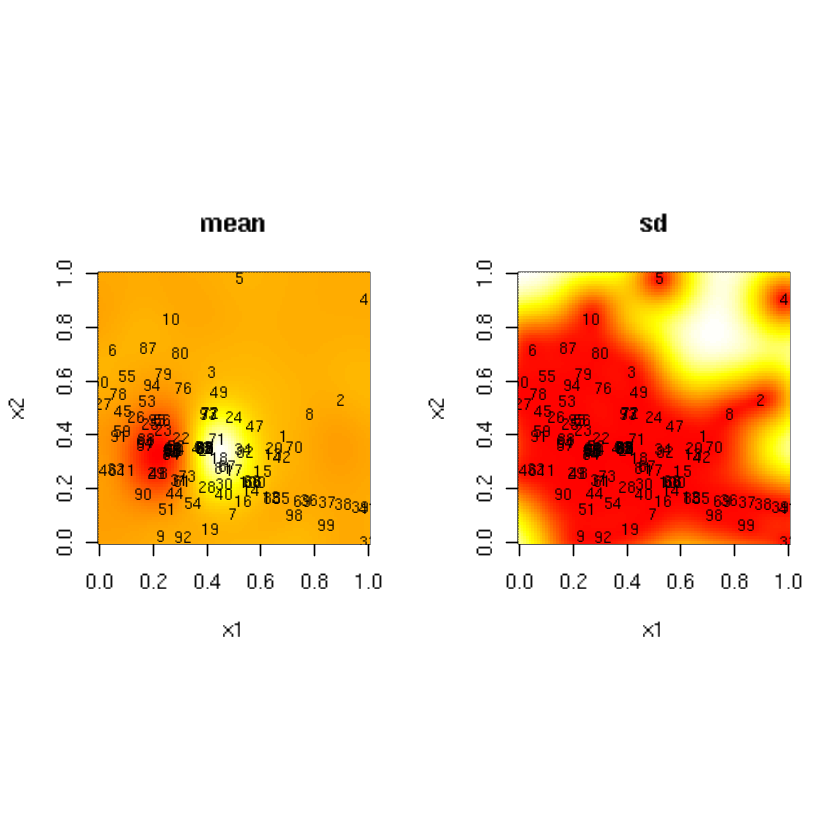

In [105]:
par(mfrow=c(1,2), pty="s")
image(x1, x2, matrix(p$mean, ncol=length(x1)), col=cols, main="mean")
text(X, labels=1:nrow(X), cex=0.75)
image(x1, x2, matrix(sqrt(p$s2), ncol=length(x1)), col=cols, main="sd")
text(X, labels=1:nrow(X), cex=0.75)


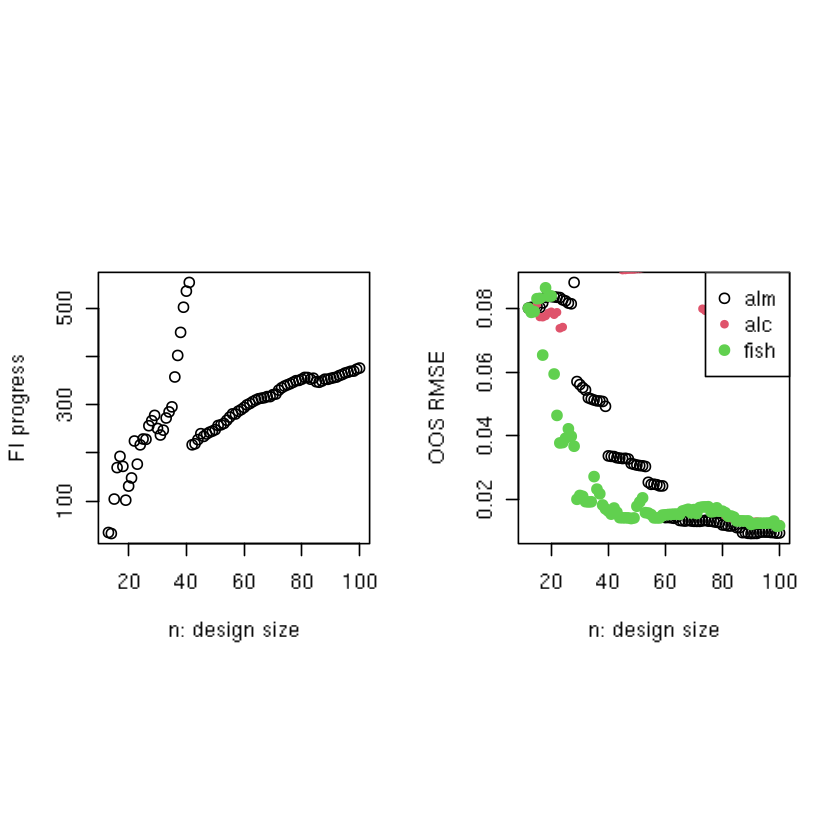

In [106]:
par(mfrow=c(1,2), pty="s")
plot((ninit+1):nrow(X), prog.fish, xlab="n: design size", 
  ylab="FI progress") 
plot(ninit:nrow(X), rmse, xlab="n: design size", ylab="OOS RMSE")
points(ninit:nrow(X), rmse.alc, col=2, pch=20)
points(ninit:nrow(X), rmse.fish, col=3, pch=19)
legend("topright", c("alm", "alc", "fish"), pch=21:19, col=1:3)